In [1]:
from copy import copy
import math
import os
from pathlib import Path
import random
import shutil
import sys
sys.path.insert(0,'..')
from matplotlib import cm
import matplotlib.colors as colors
import matplotlib.pyplot as plt
import numpy as np
from openstudio import isomodel
import pandas as pd
import seaborn as sns
from doe_xstock.database import SQLiteDatabase
from doe_xstock.simulate import OpenStudioModelEditor
from doe_xstock.utilities import write_data

In [2]:
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0
DATABASE_FILEPATH = '/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/database.db'
DATABASE = SQLiteDatabase(DATABASE_FILEPATH)

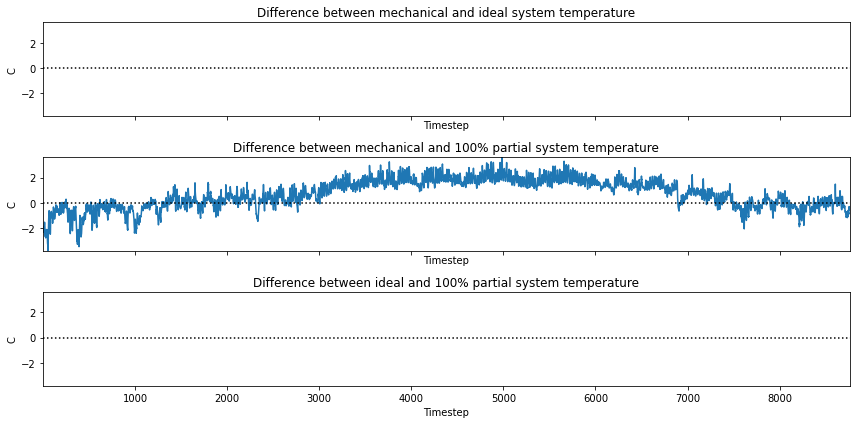

AssertionError: 

In [12]:
query = f"""
SELECT
    s.metadata_id,
    s.reference,
    l.timestep,
    l.cooling_load/i.cooling_load AS cooling_load_multiplier,
    l.heating_load/i.heating_load AS heating_load_multiplier,
    w.cooling_load AS mechanical_cooling_load,
    w.heating_load AS mechanical_heating_load,
    i.cooling_load AS ideal_cooling_load,
    i.heating_load AS ideal_heating_load,
    w.average_indoor_air_temperature AS mechanical_temperature,
    i.average_indoor_air_temperature AS ideal_temperature,
    l.average_indoor_air_temperature AS other_equipment_temperature,
    w.average_indoor_air_temperature - i.average_indoor_air_temperature AS mechanical_ideal_temperature_difference,
    w.average_indoor_air_temperature - l.average_indoor_air_temperature AS mechanical_other_equipment_temperature_difference,
    i.average_indoor_air_temperature - l.average_indoor_air_temperature AS ideal_other_equipment_temperature_difference,
    e.setpoint,
    l.average_indoor_air_temperature - e.setpoint AS other_equipment_setpoint_difference
FROM lstm_train_data l
LEFT JOIN energyplus_simulation s ON
    s.id = l.simulation_id
LEFT JOIN metadata m ON
    m.id = s.metadata_id
LEFT JOIN (SELECT * FROM energyplus_simulation WHERE reference = 0) t ON 
    t.metadata_id = s.metadata_id
LEFT JOIN energyplus_mechanical_system_simulation w ON 
    w.simulation_id = t.id AND w.timestep = l.timestep
LEFT JOIN (SELECT * FROM energyplus_simulation WHERE reference = 1) h ON 
    h.metadata_id = s.metadata_id
LEFT JOIN energyplus_ideal_system_simulation i ON 
    i.simulation_id = h.id AND i.timestep = l.timestep
LEFT JOIN ecobee_timeseries e ON e.timestep = l.timestep AND e.building_id = t.ecobee_building_id
WHERE m.bldg_id = 101010
;
"""
data = DATABASE.query_table(query)

# temperature difference time series
row_count, column_count = 3, 1
fig, axs = plt.subplots(row_count, column_count, figsize=(12*column_count,2*row_count), sharex=True, sharey=True)
plot_data = data[data['reference']==2].copy()
x, y1, y2, y3 = plot_data['timestep'], plot_data['mechanical_ideal_temperature_difference'], plot_data['mechanical_other_equipment_temperature_difference'], plot_data['ideal_other_equipment_temperature_difference']
axs[0].plot(x,y1)
axs[1].plot(x,y2)
axs[2].plot(x,y3)
axs[0].set_title('Difference between mechanical and ideal system temperature')
axs[1].set_title('Difference between mechanical and 100% partial system temperature')
axs[2].set_title('Difference between ideal and 100% partial system temperature')

for ax in fig.axes:
    ax.axhline(0, color='black', linestyle=':')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('C')

plt.tight_layout()
plt.show()

assert False

# load difference time series
row_count, column_count = 2, 1
fig, axs = plt.subplots(row_count, column_count, figsize=(12*column_count,2*row_count), sharex=True, sharey=True)
x = plot_data['timestep']
y11, y12 = plot_data['mechanical_cooling_load'], plot_data['ideal_cooling_load']
y21, y22 = plot_data['mechanical_heating_load'], plot_data['ideal_heating_load']
axs[0].plot(x,y11)
axs[0].plot(x,y12)
axs[1].plot(x,y21)
axs[1].plot(x,y22)
axs[0].set_title('Difference between mechanical and ideal system cooling load')
axs[1].set_title('Difference between mechanical and ideal system heating load')

for ax in fig.axes:
    ax.axhline(0, color='black', linestyle=':')
    ax.set_xlabel('Timestep')
    ax.set_ylabel('W')

plt.tight_layout()
plt.show()

# temperature difference duration curve
row_count, column_count = 1, 1
fig, ax = plt.subplots(row_count, column_count, figsize=(12,2))
y1 = plot_data.sort_values(
    'mechanical_ideal_temperature_difference', ascending=False
)['mechanical_ideal_temperature_difference'].tolist()
y2 = plot_data.sort_values(
    'ideal_other_equipment_temperature_difference', ascending=False
)['ideal_other_equipment_temperature_difference'].tolist()
ax.plot(y1, label='mechanical - ideal')
ax.plot(y2, label='ideal - 100% partial')
ax.set_xlabel('Timestep')
ax.set_ylabel('C')
ax.axhline(0, color='black', linestyle=':')
# ax.spines[['right','top','left','bottom']].set_visible(False)
ax.set_title('Temperature difference distribution curve')
ax.legend()
plt.tight_layout()
plt.show()

# setpoint time series
row_count, column_count = 1, 1
fig, ax = plt.subplots(row_count, column_count, figsize=(12,2))

x, y1, y2 = plot_data['timestep'], plot_data['setpoint'], plot_data['other_equipment_temperature']
ax.plot(x, y1, color='blue', label='setpoint')
ax.plot(x, y2, color='black', label='temperature')
ax.set_xlabel('Timestep')
ax.set_ylabel('C')
ax.set_title('Setpoint temperature')
ax.legend()
plt.tight_layout()
plt.show()

# temperature-setpoint difference time series
row_count, column_count = 1, 1
fig, ax = plt.subplots(row_count, column_count, figsize=(12*column_count,2*row_count), sharex=True, sharey=True)
plot_data = data[data['reference']==2].copy()
x, y1 = plot_data['timestep'], plot_data['other_equipment_setpoint_difference']
ax.plot(x,y1)
ax.set_title('Difference between 100% partial system temperature and setpoint')
ax.axhline(0, color='black', linestyle=':')
ax.set_xlabel('Timestep')
ax.set_ylabel('C')
plt.show()

# temperature-setpoint difference duration curve
row_count, column_count = 1, 1
fig, ax = plt.subplots(row_count, column_count, figsize=(12,2))
y = plot_data.sort_values(
    'other_equipment_setpoint_difference', ascending=False
)['other_equipment_setpoint_difference'].tolist()
ax.plot(y, label='100% partial system temperature and setpoint')
ax.set_xlabel('Timestep')
ax.set_ylabel('C')
ax.axhline(0, color='black', linestyle=':')
# ax.spines[['right','top','left','bottom']].set_visible(False)
ax.set_title('Temperature difference distribution curve')
ax.legend()
plt.tight_layout()
plt.show()

# temperature difference duration curve between partial load setpoint and cooling setpoint
row_count = 2
column_count = 1
fig, axs = plt.subplots(row_count, column_count, figsize=(12,2*row_count))

for r, r_data in data[data['reference']>=2].groupby('reference'):
    x, y1 = r_data['timestep'], r_data['other_equipment_setpoint_difference']
    y2 = r_data.sort_values(
        'other_equipment_setpoint_difference', ascending=False
    )['other_equipment_setpoint_difference'].tolist()
    axs[0].scatter(x, y1, label=r)
    axs[1].plot(y2, label=r)

for ax in fig.axes:
    ax.legend()

# temperature difference duration curve between partial load setpoint and setpoint
plot_data = data[data['reference']>=2].copy()
row_count = 1
column_count = len(plot_data['reference'].unique())
fig, axs = plt.subplots(row_count, column_count, figsize=(4*column_count,2*row_count))

for ax, (r, r_data) in zip(fig.axes, plot_data.groupby('reference')):
    y = r_data['other_equipment_setpoint_difference']
    ax.hist(y, bins=15)
    ax.set_title(r)

plt.tight_layout()
plt.show()

# temperature difference duration curve between partial load setpoint and setpoint
plot_data = data[data['reference']>=4].copy()
row_count = 1
column_count = len(plot_data['reference'].unique())
fig, axs = plt.subplots(row_count, column_count, figsize=(4*column_count,4*row_count))

for ax, (r, r_data) in zip(fig.axes, plot_data.groupby('reference')):
    x = r_data['other_equipment_setpoint_difference']
    y = r_data['cooling_load_multiplier']
    ax.scatter(x, y)
    ax.set_title(r)

plt.tight_layout()
plt.show()

<AxesSubplot:>

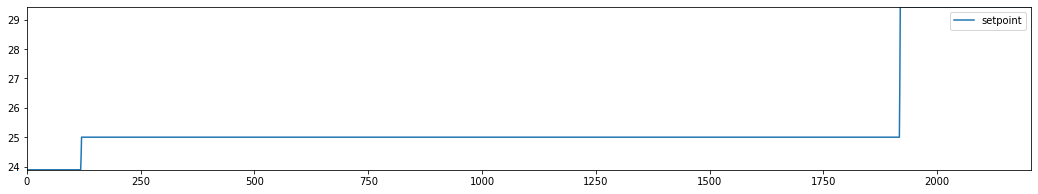

In [11]:
DATABASE.query_table("""
SELECT
    e.timestep,
    e.setpoint
FROM ecobee_timeseries e
WHERE e.building_id = (SELECT ecobee_building_id FROM energyplus_simulation WHERE metadata_id = (SELECT id FROM metadata WHERE bldg_id = 374138)  LIMIT 1)
AND timestep BETWEEN 3625 AND 5832
""")[['setpoint']].plot(figsize=(18,3))

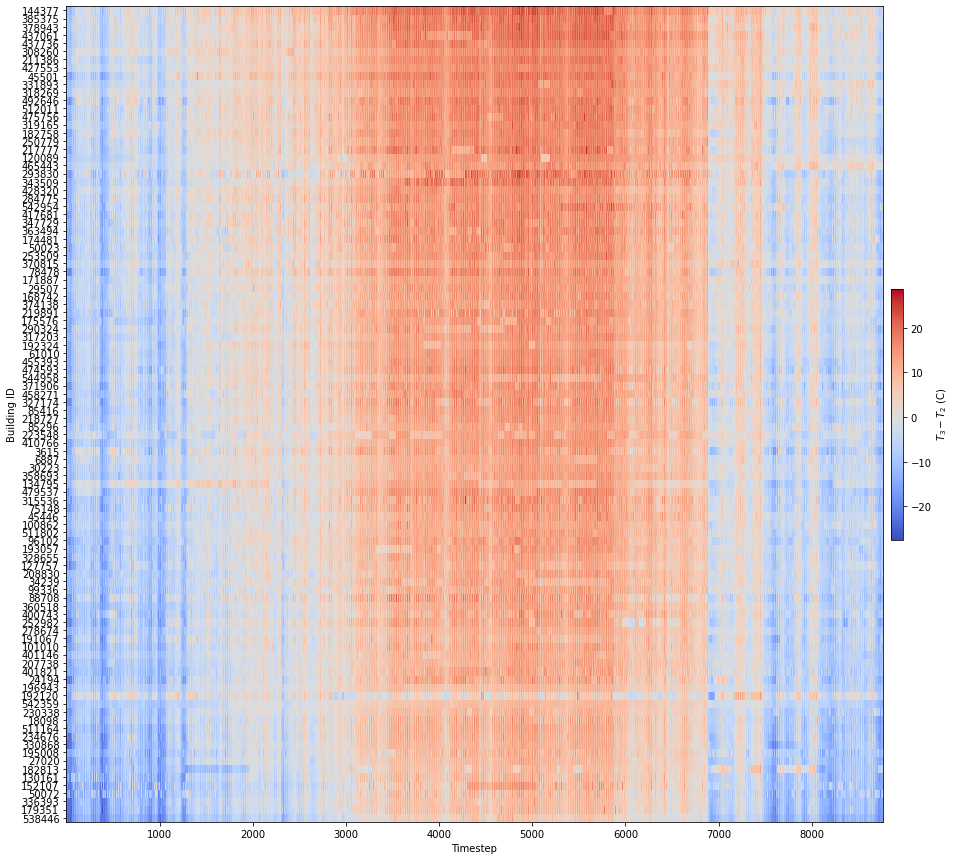

In [8]:
plot_data = DATABASE.query_table("""
SELECT
    m.bldg_id,
    l2.timestep,
    l3.average_indoor_air_temperature - l2.average_indoor_air_temperature AS value
FROM (SELECT * FROM energyplus_simulation WHERE reference = 2) t
LEFT JOIN (SELECT * FROM energyplus_simulation WHERE reference = 3) h ON 
    h.metadata_id = t.metadata_id
LEFT JOIN metadata m ON
    m.id = t.metadata_id
LEFT JOIN lstm_train_data l2 ON
    l2.simulation_id = t.id
LEFT JOIN lstm_train_data l3 ON
    l3.simulation_id = h.id AND l3.timestep = l2.timestep
;
""")
plot_data = plot_data.pivot(index='bldg_id',columns='timestep',values='value')
plot_data.index = plot_data.index.astype(str)

# y ordering
y_order = plot_data.sum(axis=1).sort_values()
y_order = pd.DataFrame(y_order)
y_order['order'] = y_order.reset_index().index
plot_data = plot_data.merge(y_order[['order']],how='left',left_index=True,right_index=True)
plot_data = plot_data.sort_values('order').drop(columns=['order'])

x, y, z = plot_data.columns.tolist(), plot_data.index.tolist(), plot_data.values
cmap = 'coolwarm'
norm = colors.TwoSlopeNorm(vcenter=0)
fig, ax = plt.subplots(1,1,figsize=(15,15))
pcm = ax.pcolormesh(x,y,z,shading='nearest',norm=norm,cmap=cmap,edgecolors='black',linewidth=0.0)
_ = fig.colorbar(pcm,ax=ax,orientation='vertical',label=r'$T_3 - T_2$ (C)',fraction=0.015,pad=0.01)
ax.tick_params('x',which='both',rotation=0)
ax.set_xlabel('Timestep')
ax.set_ylabel('Building ID')
plt.show()

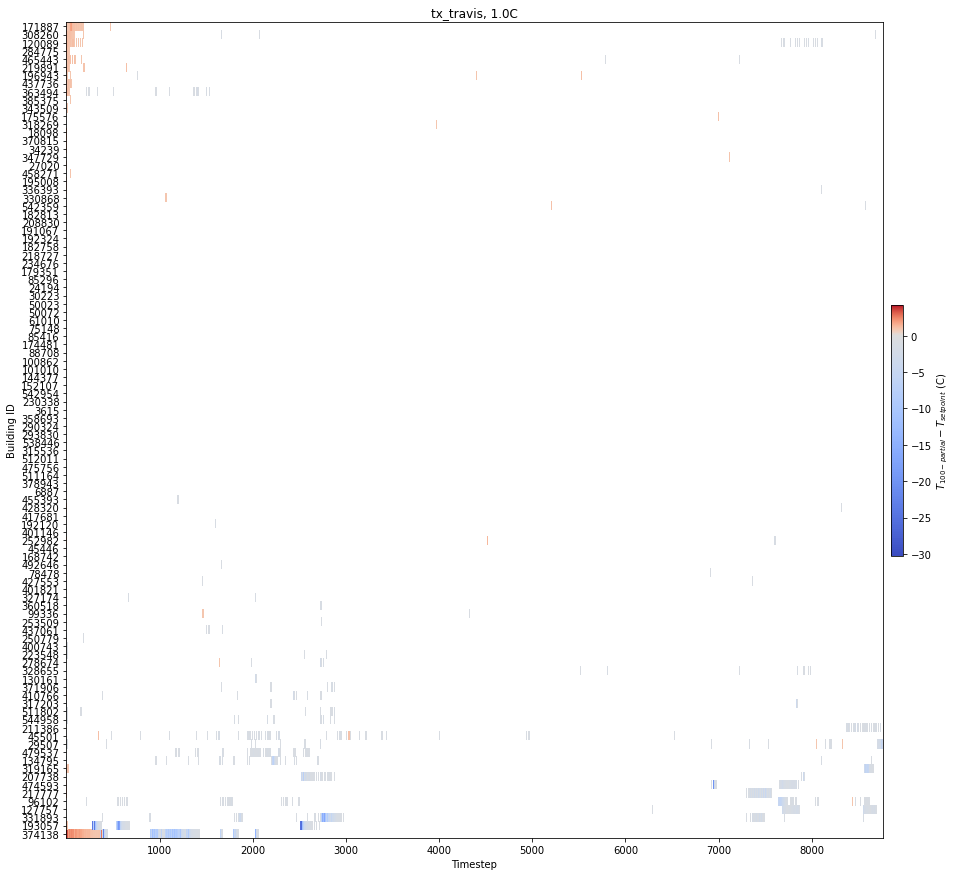

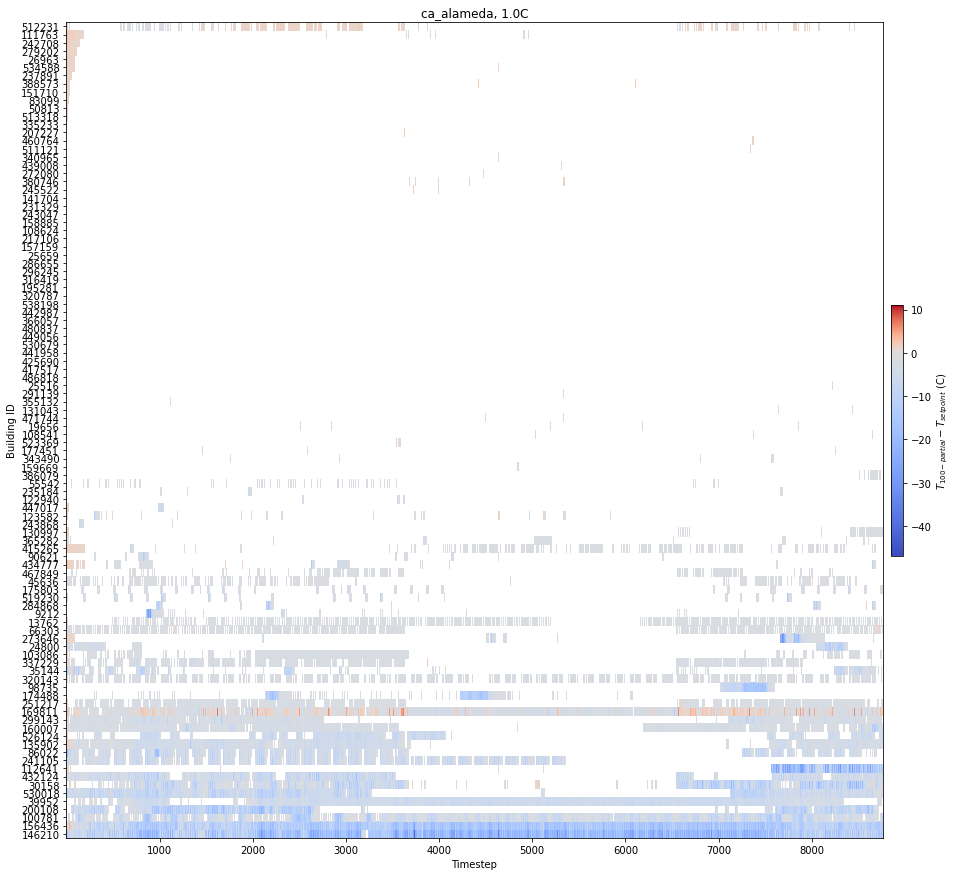

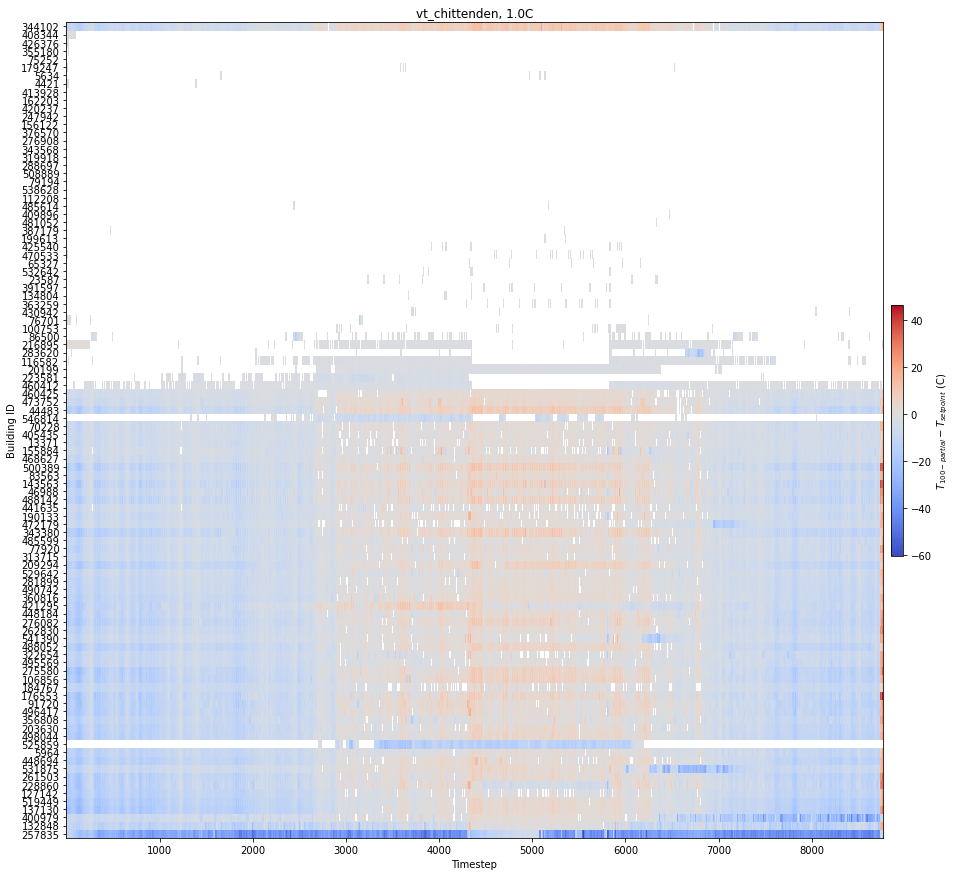

In [18]:
limit = 1.0
data_list = []

neighborhoods = [
    'tx_travis',
    'ca_alameda',
    'vt_chittenden'
]

for n in neighborhoods:
    filepath = os.path.join(Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/doe_xstock/data/neighborhood'), f'{n}_county_neighborhood.csv')
    n_data = pd.read_csv(filepath, sep='|')
    metadata_ids = n_data['metadata_id'].tolist()
    metadata_ids = tuple(metadata_ids)
    plot_data = DATABASE.query_table(f"""
    SELECT
        m.bldg_id,
        l.timestep,
        l.average_indoor_air_temperature - e.setpoint AS value
    FROM (SELECT * FROM energyplus_simulation WHERE reference = 2 AND metadata_id IN {metadata_ids}) t
    LEFT JOIN metadata m ON
        m.id = t.metadata_id
    LEFT JOIN lstm_train_data l ON
        l.simulation_id = t.id
    LEFT JOIN ecobee_timeseries e ON 
        e.building_id = t.ecobee_building_id AND e.timestep = l.timestep
    ;
    """)
    plot_data.loc[plot_data['value'].abs() < limit,'value'] = None
    plot_data = plot_data.pivot(index='bldg_id',columns='timestep',values='value')
    plot_data.index = plot_data.index.astype(str)

    # y ordering
    y_order = plot_data.sum(axis=1).sort_values()
    y_order = pd.DataFrame(y_order)
    y_order['order'] = y_order.reset_index().index
    plot_data = plot_data.merge(y_order[['order']],how='left',left_index=True,right_index=True)
    plot_data = plot_data.sort_values('order').drop(columns=['order'])

    x, y, z = plot_data.columns.tolist(), plot_data.index.tolist(), plot_data.values
    cmap = 'coolwarm'
    norm = colors.TwoSlopeNorm(vcenter=0)
    fig, ax = plt.subplots(1,1,figsize=(15,15))
    pcm = ax.pcolormesh(x,y,z,shading='nearest',norm=norm,cmap=cmap,edgecolors='black',linewidth=0.0)
    _ = fig.colorbar(pcm,ax=ax,orientation='vertical',label=r'$T_{100-partial} - T_{setpoint}$ (C)',fraction=0.015,pad=0.01)
    ax.tick_params('x',which='both',rotation=0)
    ax.set_xlabel('Timestep')
    ax.set_ylabel('Building ID')
    ax.set_title(f'{n}, {limit}C')
    plt.show()

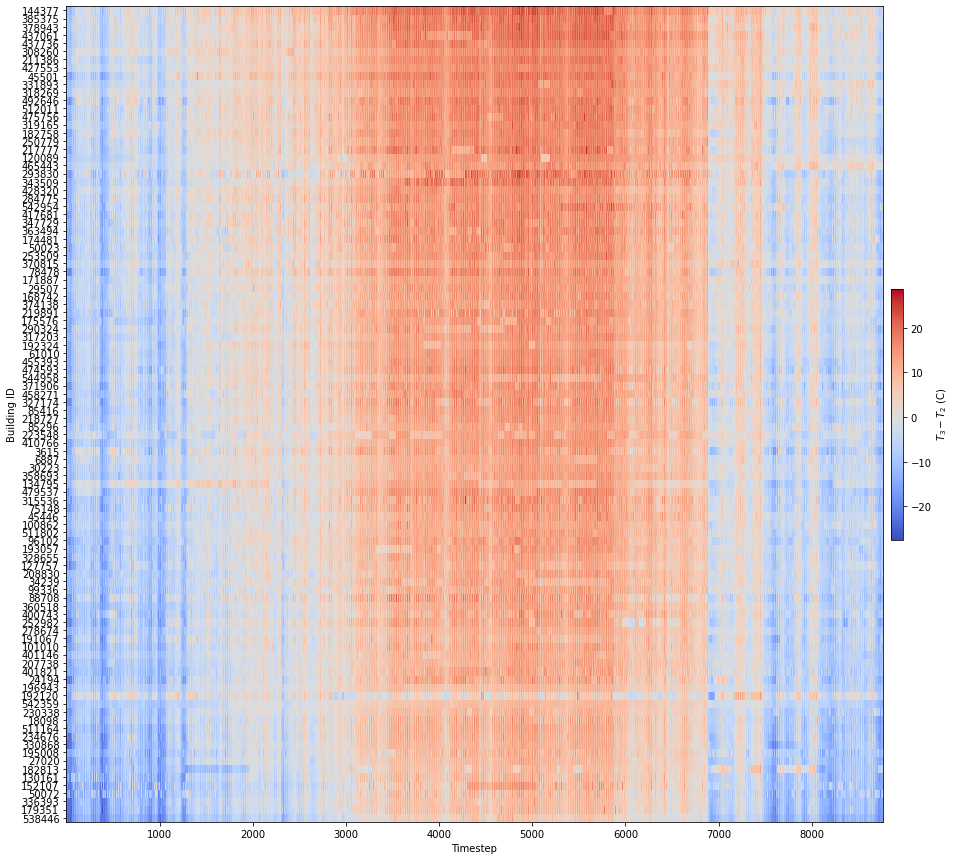

In [10]:
plot_data = DATABASE.query_table("""
SELECT
    m.bldg_id,
    l2.timestep,
    l3.average_indoor_air_temperature - l2.average_indoor_air_temperature AS value
FROM (SELECT * FROM energyplus_simulation WHERE reference = 2) t
LEFT JOIN (SELECT * FROM energyplus_simulation WHERE reference = 3) h ON 
    h.metadata_id = t.metadata_id
LEFT JOIN metadata m ON
    m.id = t.metadata_id
LEFT JOIN lstm_train_data l2 ON
    l2.simulation_id = t.id
LEFT JOIN lstm_train_data l3 ON
    l3.simulation_id = h.id AND l3.timestep = l2.timestep
;
""")
plot_data = plot_data.pivot(index='bldg_id',columns='timestep',values='value')
plot_data.index = plot_data.index.astype(str)

# y ordering
y_order = plot_data.sum(axis=1).sort_values()
y_order = pd.DataFrame(y_order)
y_order['order'] = y_order.reset_index().index
plot_data = plot_data.merge(y_order[['order']],how='left',left_index=True,right_index=True)
plot_data = plot_data.sort_values('order').drop(columns=['order'])

x, y, z = plot_data.columns.tolist(), plot_data.index.tolist(), plot_data.values
cmap = 'coolwarm'
norm = colors.TwoSlopeNorm(vcenter=0)
fig, ax = plt.subplots(1,1,figsize=(15,15))
pcm = ax.pcolormesh(x,y,z,shading='nearest',norm=norm,cmap=cmap,edgecolors='black',linewidth=0.0)
_ = fig.colorbar(pcm,ax=ax,orientation='vertical',label=r'$T_3 - T_2$ (C)',fraction=0.015,pad=0.01)
ax.tick_params('x',which='both',rotation=0)
ax.set_xlabel('Timestep')
ax.set_ylabel('Building ID')
plt.show()

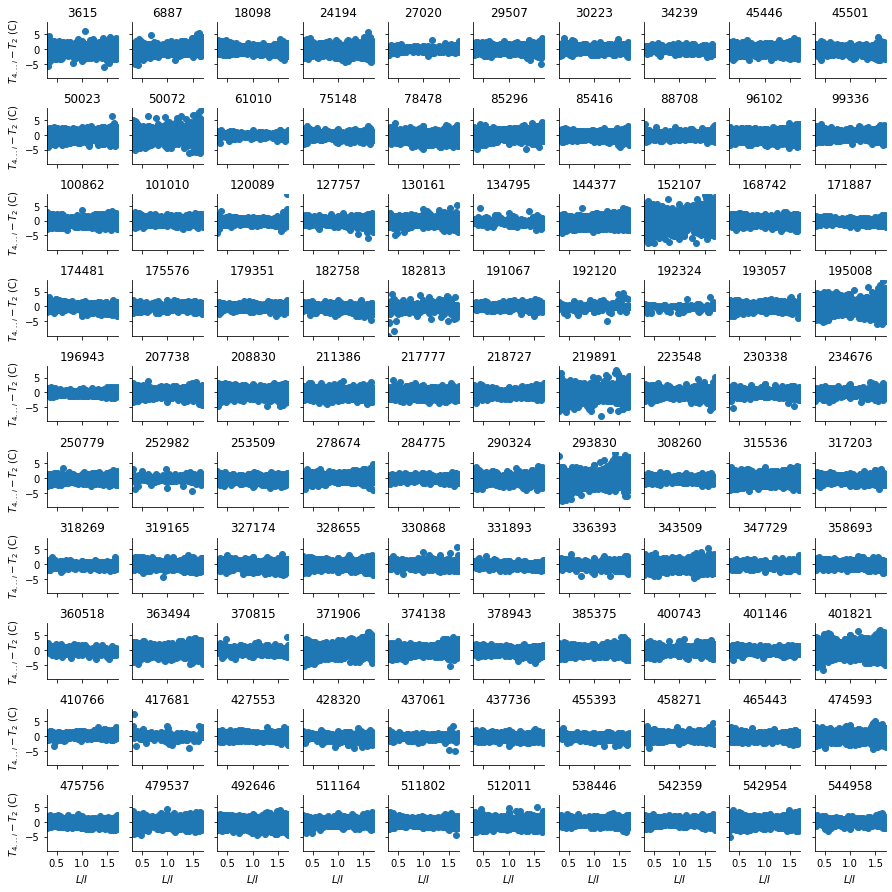

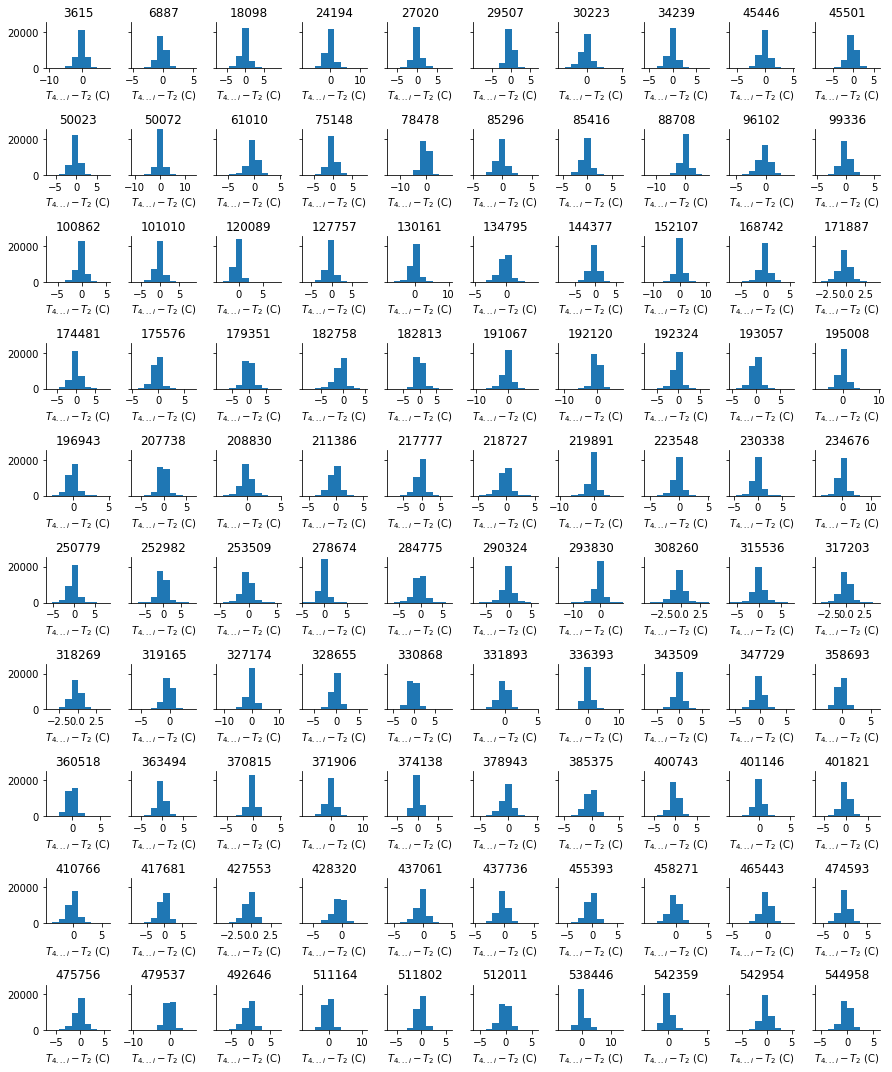

In [89]:
plot_data = DATABASE.query_table("""
SELECT
    m.bldg_id,
    l2.timestep,
    MAX(l3.cooling_load/l2.cooling_load, l3.heating_load/l2.heating_load) AS multiplier,
    l3.average_indoor_air_temperature - l2.average_indoor_air_temperature AS value
FROM (SELECT * FROM energyplus_simulation WHERE reference = 2) t
LEFT JOIN (SELECT * FROM energyplus_simulation WHERE reference > 3) h ON 
    h.metadata_id = t.metadata_id
LEFT JOIN metadata m ON
    m.id = t.metadata_id
LEFT JOIN lstm_train_data l2 ON
    l2.simulation_id = t.id
LEFT JOIN lstm_train_data l3 ON
    l3.simulation_id = h.id AND l3.timestep = l2.timestep
""")

column_count_limit = 10
bldg_id_count = len(plot_data['bldg_id'].unique())
row_count = math.ceil(bldg_id_count/column_count_limit)
column_count = min(column_count_limit, bldg_id_count)

# scatter
fig, axs = plt.subplots(row_count, column_count, figsize=(1.25*column_count,1.25*row_count), sharex=True, sharey=True)

for i, (ax, (bldg_id, b_data)) in enumerate(zip(fig.axes, plot_data.groupby('bldg_id'))):
    x, y = b_data['multiplier'], b_data['value']
    ax.scatter(x,y)
    ax.set_title(bldg_id)

    if i%column_count_limit == 0:
        ax.set_ylabel(r'$T_{4...i} - T_2$ (C)')
    else:
        ax.set_ylabel(None)

    if i >= (row_count-1)*column_count:
        ax.set_xlabel(r'$L/I$')
    else:
        ax.set_xlabel(None)

    for s in ['right','top',]:
        ax.spines[s].set_visible(False)

plt.tight_layout()
plt.show()

# histogram
fig, axs = plt.subplots(row_count, column_count, figsize=(1.25*column_count,1.5*row_count), sharex=False, sharey=True)

for i, (ax, (bldg_id, b_data)) in enumerate(zip(fig.axes, plot_data.groupby('bldg_id'))):
    x, y = b_data['multiplier'], b_data['value']
    ax.hist(y)
    ax.set_title(bldg_id)
    ax.set_xlabel(r'$T_{4...i} - T_2$ (C)')

    for s in ['right','top',]:
        ax.spines[s].set_visible(False)

plt.tight_layout()
plt.show()

# Clean up files

In [51]:
db = SQLiteDatabase('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/energyplus_output/output_resstock-amy2018-2021-release-1-101010-1-ideal/resstock-amy2018-2021-release-1-101010-1-ideal.sql')
data = db.query_table("""
SELECT
    r.TimeIndex,
    r.ReportDataDictionaryIndex,
    d.Name,
    r.Value
FROM ReportData r
LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
LEFT JOIN Time t ON t.TimeIndex = r.TimeIndex
WHERE d.Name IN ('Water Heater Use Side Heat Transfer Energy')
    AND t.DayType NOT IN ('SummerDesignDay', 'WinterDesignDay')
ORDER BY r.TimeIndex ASC
""")
data.describe()

,TimeIndex,ReportDataDictionaryIndex,Value
count,8760.000000,8760.0,8.760000e+03
mean,4380.500000,1819.0,-7.290164e+05
std,2528.938512,0.0,2.169723e+06
min,1.000000,1819.0,-1.920461e+07
25%,2190.750000,1819.0,0.000000e+00
50%,4380.500000,1819.0,0.000000e+00
75%,6570.250000,1819.0,0.000000e+00
max,8760.000000,1819.0,0.000000e+00


In [4]:
# to_keep = {
#     'simulation_id':[
#         '_schedules.csv',
#         '_schedule.csv',
#         '_setpoint.csv',
#         '_setpoints.csv',
#         '_partial_load.csv',
#         '_partial_loads.csv',
#         '.err',
#         '.idf',
#         '.sql',
#         '.rdd',
#         '.mdd',
#     ],
#     'other':[
#         'weather.epw'
#     ]
# }
# energyplus_output_directory = Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/energyplus_output')
# output_directories = os.listdir(energyplus_output_directory)

# for i, d in enumerate(output_directories):
#     print(f'\r{i+1}/{len(output_directories)}', end=" "*30)

#     if 'resstock' in d:
#         sim_id = d.replace('output_','')
#         files = os.listdir(os.path.join(energyplus_output_directory, d))
#         valid_files = [f'{sim_id}{f}' for f in to_keep['simulation_id']]
#         valid_files += to_keep['other']
#         invalid_files = [f for f in files if f not in valid_files]

#         for f in invalid_files:
#             os.remove(os.path.join(energyplus_output_directory, d, f))
        
#     else:
#         continue

2401/2401                              

In [41]:
# # get diffuse solar radiation
# sim_ids = {
#     'CA, Alameda County': 519230,
#     'TX, Travis County': 101010,
#     'VT, Chittenden County': 276908,
# }
# data_list = []

# for k, v in sim_ids.items():
#     sim_id = f'resstock-amy2018-2021-release-1-{v}-0-mechanical'
#     filepath = os.path.join(energyplus_output_directory, f'output_{sim_id}',f'{sim_id}.sql')
#     db = SQLiteDatabase(filepath)
#     data = db.query_table("""
#     SELECT
#         r.TimeIndex,
#         r.ReportDataDictionaryIndex,
#         d.Name,
#         r.Value
#     FROM ReportData r
#     LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
#     LEFT JOIN Time t ON t.TimeIndex = r.TimeIndex
#     WHERE d.Name IN ('Site Diffuse Solar Radiation Rate per Area')
#         AND t.DayType NOT IN ('SummerDesignDay', 'WinterDesignDay')
#     ORDER BY r.TimeIndex ASC
#     """)
#     data['location'] = k
#     data['timestep'] = data.index + 1
#     data_list.append(data)

# diffuse_data = pd.concat(data_list, ignore_index=True, sort=False)
    
#     # e_sim_ids = tuple(DATABASE.query_table(f"""
#     # SELECT
#     #     e.id
#     # FROM energyplus_simulation e
#     # INNER JOIN metadata m ON m.id = e.metadata_id
#     # WHERE m.in_resstock_county_id = '{k}'
#     # """)['id'].tolist())
#     # count = data.groupby('Value').size().shape[0]
#     # i = 1

#     # for v, v_data in data.groupby('Value'):
#     #     print(f'\r{k} - {i}/{count}', end=' '*30)
#     #     timesteps = tuple(v_data['timestep'].tolist())
#     #     DATABASE.query(f"""
#     #     UPDATE lstm_train_data
#     #     SET diffuse_solar_radiation = {v}
#     #     WHERE timestep IN {timesteps} AND simulation_id IN {e_sim_ids}
#     #     """)
#     #     i += 1

In [49]:
# energyplus_output_directory = Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/energyplus_output')
# query = """
# WITH u AS (
#     -- site variables
    # SELECT
    #     r.TimeIndex,
    #     r.ReportDataDictionaryIndex,
    #     'site_variable' AS label,
    #     r.Value
    # FROM ReportData r
    # LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
    # WHERE d.Name IN ('Site Direct Solar Radiation Rate per Area', 'Site Diffuse Solar Radiation Rate per Area', 'Site Outdoor Air Drybulb Temperature')

#     UNION ALL

#     -- weighted conditioned zone variables
#     SELECT
#         r.TimeIndex,
#         r.ReportDataDictionaryIndex,
#         'weighted_variable' AS label,
#         r.Value
#     FROM weighted_variable r
#     LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
#     WHERE d.Name IN ('Zone Air Temperature')

#     UNION ALL

#     -- thermal load variables
#     SELECT
#         r.TimeIndex,
#         r.ReportDataDictionaryIndex,
#         CASE WHEN r.Value > 0 THEN 'heating_load' ELSE 'cooling_load' END AS label,
#         ABS(r.Value) AS Value
#     FROM ReportData r
#     LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
#     WHERE 
#         d.Name = 'Other Equipment Convective Heating Rate' AND
#         (d.KeyValue LIKE '%HEATING LOAD' OR d.KeyValue LIKE '%COOLING LOAD')

#     UNION ALL

#     -- other variables
#     SELECT
#         r.TimeIndex,
#         r.ReportDataDictionaryIndex,
#         'occupant_count' AS label,
#         r.Value
#     FROM ReportData r
#     LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
#     WHERE 
#         d.Name = 'Zone People Occupant Count'
# ), p AS (
#     SELECT
#         u.TimeIndex,
#         MAX(CASE WHEN d.Name = 'Site Direct Solar Radiation Rate per Area' THEN Value END) AS direct_solar_radiation,
#         MAX(CASE WHEN d.Name = 'Site Diffuse Solar Radiation Rate per Area' THEN Value END) AS diffuse_solar_radiation,
#         MAX(CASE WHEN d.Name = 'Site Outdoor Air Drybulb Temperature' THEN Value END) AS outdoor_air_temperature,
#         SUM(CASE WHEN d.Name = 'Zone Air Temperature' THEN Value END) AS average_indoor_air_temperature,
#         SUM(CASE WHEN d.Name = 'Zone People Occupant Count' THEN Value END) AS occupant_count,
#         SUM(CASE WHEN u.label = 'cooling_load' THEN Value END) AS cooling_load,
#         SUM(CASE WHEN u.label = 'heating_load' THEN Value END) AS heating_load
#     FROM u
#     LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = u.ReportDataDictionaryIndex
#     GROUP BY u.TimeIndex
# )
# SELECT
#     t.TimeIndex AS timestep,
#     t.Month AS month,
#     t.Day AS day,
#     t.DayType AS day_name,
#     CASE
#         WHEN t.DayType = 'Monday' THEN 1
#         WHEN t.DayType = 'Tuesday' THEN 2
#         WHEN t.DayType = 'Wednesday' THEN 3
#         WHEN t.DayType = 'Thursday' THEN 4
#         WHEN t.DayType = 'Friday' THEN 5
#         WHEN t.DayType = 'Saturday' THEN 6
#         WHEN t.DayType = 'Sunday' THEN 7
#         WHEN t.DayType = 'Holiday' THEN 8
#         ELSE NULL
#     END AS day_of_week,
#     t.Hour AS hour,
#     t.Minute AS minute,
#     p.direct_solar_radiation,
#     p.diffuse_solar_radiation,
#     p.outdoor_air_temperature,
#     p.average_indoor_air_temperature,
#     p.occupant_count,
#     COALESCE(p.cooling_load, 0) AS cooling_load,
#     COALESCE(p.heating_load, 0) AS heating_load
# FROM p
# LEFT JOIN Time t ON t.TimeIndex = p.TimeIndex
# WHERE t.DayType NOT IN ('SummerDesignDay', 'WinterDesignDay')
# """
# directories = sorted([d for d in os.listdir(energyplus_output_directory) if d.endswith('partial')])

# for i, d in enumerate(directories):
#     print(f'\r{i+1}/{len(directories)}', end=' '*30)
#     bldg_id = d.split('-')[-3]
#     reference = d.split('-')[-2]
#     sim_id = d.replace('output_','')
#     db = SQLiteDatabase(os.path.join(energyplus_output_directory, d, f'{sim_id}.sql'))
#     data = db.query_table(query)
#     location = DATABASE.query_table(f"SELECT in_resstock_county_id FROM metadata WHERE bldg_id = {bldg_id}")['in_resstock_county_id'].iloc[0]
#     data['diffuse_solar_radiation'] = diffuse_data[diffuse_data['location']==location]['Value'].tolist()

#     train_data_query = f"""
#     INSERT INTO lstm_train_data (simulation_id, timestep, month, day, day_name, day_of_week, hour, minute, direct_solar_radiation, diffuse_solar_radiation, outdoor_air_temperature, average_indoor_air_temperature, occupant_count, cooling_load, heating_load)
#     VALUES (
#         (SELECT id FROM energyplus_simulation WHERE reference = {reference} AND metadata_id = (SELECT id FROM metadata WHERE bldg_id = {bldg_id})),
#         :timestep, :month, :day, :day_name, :day_of_week, :hour, :minute, :direct_solar_radiation, :diffuse_solar_radiation, :outdoor_air_temperature, :average_indoor_air_temperature, :occupant_count, :cooling_load, :heating_load
#     );
#     """
#     values = data.to_records(index=False)
#     DATABASE.insert_batch([train_data_query], [values])

1800/1800                              

### Comparing mechanical and ideal cooling loads

In [6]:
# select buildings where ideal loads are indeed being met
limit = 0.5
data_list = []

neighborhoods = {
    'tx_travis': (3625, 5832),
    'ca_alameda': (1, 2088),
    'vt_chittenden': (1, 2088)
}

for n in neighborhoods:
    filepath = os.path.join(Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/doe_xstock/data/neighborhood'), f'{n}_county_neighborhood.csv')
    n_data = pd.read_csv(filepath, sep='|')
    metadata_ids = n_data['metadata_id'].tolist()
    metadata_ids = tuple(metadata_ids)
    start_timestep, end_timestep = neighborhoods[n]
    data = DATABASE.query_table(f"""
    SELECT
        m.bldg_id,
        e.timestep,
        (w.cooling_load - e.cooling_load)/e.cooling_load AS value
    FROM (SELECT * FROM energyplus_simulation WHERE reference = 0 AND metadata_id IN {metadata_ids}) n
    LEFT JOIN (SELECT * FROM energyplus_simulation WHERE reference = 1 AND metadata_id IN {metadata_ids}) t ON
        t.metadata_id = n.metadata_id
    LEFT JOIN energyplus_mechanical_system_simulation e ON
        e.simulation_id = n.id
    LEFT JOIN energyplus_ideal_system_simulation w ON
        w.simulation_id = t.id
        AND w.timestep = e.timestep
    LEFT JOIN metadata m ON
        m.id = t.metadata_id
    ;
    """)

    if data.shape[0] == 0:
        pass
    
    else:
        # HEATMAP
        plot_data = data.copy()
        plot_data.loc[plot_data['value'].abs() < limit,'value'] = None
        plot_data['county'] = n
        plot_data = plot_data.reset_index()
        data_list.append(plot_data)
        plot_data = plot_data.pivot(index='bldg_id',columns='timestep',values='value')
        plot_data.index = plot_data.index.astype(str)

        # y ordering
        y_order = plot_data.sum(axis=1).sort_values()
        y_order = pd.DataFrame(y_order)
        y_order['order'] = y_order.reset_index().index
        plot_data = plot_data.merge(y_order[['order']],how='left',left_index=True,right_index=True)
        plot_data = plot_data.sort_values('order').drop(columns=['order'])

        x, y, z = plot_data.columns.tolist(), plot_data.index.tolist(), plot_data.values
        cmap = 'coolwarm'
        norm = colors.TwoSlopeNorm(vcenter=0, vmax=1.0)
        fig, ax = plt.subplots(1,1,figsize=(15,10))
        pcm = ax.pcolormesh(x,y,z,shading='nearest',norm=norm,cmap=cmap,edgecolors='black',linewidth=0.0)
        _ = fig.colorbar(pcm,ax=ax,orientation='vertical',label=r'$(Q_{ideal} - Q_{mech})/Q_{mech}$',fraction=0.015,pad=0.01)
        ax.tick_params('x',which='both',rotation=0)
        ax.set_xlabel('Timestep')
        ax.set_ylabel('Building ID')
        ax.set_title(f'{n}; timesteps = ({start_timestep}, {end_timestep}); limit = {limit} C')
        filename = f'{n.lower().replace(" ", "_").replace(",", "")}_mechanical_and_ideal_cooling_load_difference.png'
        plt.savefig(os.path.join('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/doe_xstock/figures', filename), bbox_inches='tight', transparent=False)
        plt.close()

temperature_difference_data = pd.concat(data_list, ignore_index=True)
del data_list

### Comparing mechanical and ideal heating loads

### Comparing ideal load temperature and setpoint

In [5]:
# select buildings where ideal loads are indeed being met
limit = 0.5
data_list = []

neighborhoods = {
    'tx_travis': (3625, 5832),
    'ca_alameda': (1, 2088),
    'vt_chittenden': (1, 2088)
}

for n in neighborhoods:
    filepath = os.path.join(Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/doe_xstock/data/neighborhood'), f'{n}_county_neighborhood.csv')
    n_data = pd.read_csv(filepath, sep='|')
    metadata_ids = n_data['metadata_id'].tolist()
    metadata_ids = tuple(metadata_ids)
    start_timestep, end_timestep = neighborhoods[n]
    data = DATABASE.query_table(f"""
    SELECT
        m.bldg_id,
        w.timestep,
        w.average_indoor_air_temperature - e.setpoint AS value
    FROM (SELECT * FROM energyplus_simulation WHERE reference = 1 AND metadata_id IN {metadata_ids}) t
    LEFT JOIN metadata m ON
        m.id = t.metadata_id
    LEFT JOIN energyplus_ideal_system_simulation w ON
        w.simulation_id = t.id
    LEFT JOIN ecobee_timeseries e ON 
        e.building_id = t.ecobee_building_id AND e.timestep = w.timestep
    ;
    """)

    if data.shape[0] == 0:
        pass
    
    else:
        # HEATMAP
        plot_data = data.copy()
        plot_data.loc[plot_data['value'].abs() < limit,'value'] = None
        plot_data['county'] = n
        plot_data = plot_data.reset_index()
        data_list.append(plot_data)
        plot_data = plot_data.pivot(index='bldg_id',columns='timestep',values='value')
        plot_data.index = plot_data.index.astype(str)

        # y ordering
        y_order = plot_data.sum(axis=1).sort_values()
        y_order = pd.DataFrame(y_order)
        y_order['order'] = y_order.reset_index().index
        plot_data = plot_data.merge(y_order[['order']],how='left',left_index=True,right_index=True)
        plot_data = plot_data.sort_values('order').drop(columns=['order'])

        x, y, z = plot_data.columns.tolist(), plot_data.index.tolist(), plot_data.values
        cmap = 'coolwarm'
        norm = colors.TwoSlopeNorm(vcenter=0)
        fig, ax = plt.subplots(1,1,figsize=(15,10))
        pcm = ax.pcolormesh(x,y,z,shading='nearest',norm=norm,cmap=cmap,edgecolors='black',linewidth=0.0)
        _ = fig.colorbar(pcm,ax=ax,orientation='vertical',label=r'$T_{ideal} - T_{setpoint}$ (C)',fraction=0.015,pad=0.01)
        ax.tick_params('x',which='both',rotation=0)
        ax.set_xlabel('Timestep')
        ax.set_ylabel('Building ID')
        ax.set_title(f'{n}; timesteps = ({start_timestep}, {end_timestep}); limit = {limit} C')
        filename = f'{n.lower().replace(" ", "_").replace(",", "")}_and_ideal_and_setpoint_temperature_difference.png'
        plt.savefig(os.path.join('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/doe_xstock/figures', filename), bbox_inches='tight', transparent=False)
        plt.close()

temperature_difference_data = pd.concat(data_list, ignore_index=True)
del data_list

- Pretty much all of Travis buildings are meeting setpoint
- About 50% of Alameda buildings are NOT meeting set point
- Somewhere around 80% of Chittenden buildings are meeting setpoint
- Not too sure what the case is for situations where setpoint is not met ut guess is either the reconfiguration of the building EMS to allow for ideal and partial load simulation as well as the removal of mechanical systems could have messed things up. In some cases however, the setpoint is too extreme. An example is bldg_id = 146210 in Alameda whose setpoint is ~ 7.8C on average.


Need to find a sweet spot of buildings in each county where the compromise on unmet hours is not too severe:

In [30]:
limit = 5.0
temperature_difference_data['unmet'] = 0
temperature_difference_data.loc[temperature_difference_data['value'].notnull(), 'unmet'] = 1
plot_data = temperature_difference_data.groupby(['county', 'bldg_id'])[['unmet']].sum().reset_index()
# plot_data['percentage'] = plot_data['unmet']*100.0/plot_data['county'].map(lambda x: 1 + neighborhoods[x][1] - neighborhoods[x][0])
plot_data['percentage'] = plot_data['unmet']*100.0/8760
plot_data = plot_data[plot_data['percentage']<=limit]
valid_buildings = plot_data.copy()
plot_data = plot_data.groupby('county').size().reset_index(name='count')
plot_data

,county,count
0,tx_travis,100


### Comparing 100% partial (OtherEquipment object in E+) temperature to setpoint

In [31]:
limit = 0.5
data_list = []

neighborhoods = {
    'tx_travis': (3625, 5832),
    'ca_alameda': (1, 2088),
    'vt_chittenden': (1, 2088)
}

for n in neighborhoods:
    filepath = os.path.join(Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/doe_xstock/data/neighborhood'), f'{n}_county_neighborhood.csv')
    n_data = pd.read_csv(filepath, sep='|')
    metadata_ids = n_data['metadata_id'].tolist()
    metadata_ids = tuple(metadata_ids)
    start_timestep, end_timestep = neighborhoods[n]
    plot_data = DATABASE.query_table(f"""
    SELECT
        m.bldg_id,
        l.timestep,
        l.average_indoor_air_temperature - e.setpoint AS value
    FROM (SELECT * FROM energyplus_simulation WHERE reference = 2 AND metadata_id IN {metadata_ids}) t
    LEFT JOIN metadata m ON
        m.id = t.metadata_id
    LEFT JOIN lstm_train_data l ON
        l.simulation_id = t.id
    LEFT JOIN ecobee_timeseries e ON 
        e.building_id = t.ecobee_building_id AND e.timestep = l.timestep
    WHERE l.timestep BETWEEN {start_timestep} AND {end_timestep}
    ;
    """)

    if plot_data.shape[0] == 0:
        pass

    else:
        # HEATMAP
        plot_data = plot_data.copy()
        plot_data.loc[plot_data['value'].abs() < limit,'value'] = None
        plot_data['county'] = n
        plot_data = plot_data.reset_index()
        data_list.append(plot_data)
        plot_data = plot_data.pivot(index='bldg_id',columns='timestep',values='value')
        plot_data.index = plot_data.index.astype(str)

        # y ordering
        y_order = plot_data.sum(axis=1).sort_values()
        y_order = pd.DataFrame(y_order)
        y_order['order'] = y_order.reset_index().index
        plot_data = plot_data.merge(y_order[['order']],how='left',left_index=True,right_index=True)
        plot_data = plot_data.sort_values('order').drop(columns=['order'])

        x, y, z = plot_data.columns.tolist(), plot_data.index.tolist(), plot_data.values
        cmap = 'coolwarm'
        norm = colors.TwoSlopeNorm(vcenter=0)
        fig, ax = plt.subplots(1,1,figsize=(15,10))
        pcm = ax.pcolormesh(x,y,z,shading='nearest',norm=norm,cmap=cmap,edgecolors='black',linewidth=0.0)
        _ = fig.colorbar(pcm,ax=ax,orientation='vertical',label=r'$T_{100 partial} - T_{setpoint}$ (C)',fraction=0.015,pad=0.01)
        ax.tick_params('x',which='both',rotation=0)
        ax.set_xlabel('Timestep')
        ax.set_ylabel('Building ID')
        ax.set_title(f'{n}; timesteps = ({start_timestep}, {end_timestep}); limit = {limit} C')
        filename = f'{n.lower().replace(" ", "_").replace(",", "")}_100p_and_setpoint_temperature_difference.png'
        plt.savefig(os.path.join('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/doe_xstock/figures', filename), bbox_inches='tight', transparent=False)
        plt.close()

temperature_difference_data = pd.concat(data_list, ignore_index=True)
del data_list

In [32]:
limit = 5.0
temperature_difference_data['unmet'] = 0
temperature_difference_data.loc[temperature_difference_data['value'].notnull(), 'unmet'] = 1
plot_data = temperature_difference_data.groupby(['county', 'bldg_id'])[['unmet']].sum().reset_index()
# plot_data['percentage'] = plot_data['unmet']*100.0/plot_data['county'].map(lambda x: 1 + neighborhoods[x][1] - neighborhoods[x][0])
plot_data['percentage'] = plot_data['unmet']*100.0/8760
plot_data = plot_data[plot_data['percentage']<=limit]
valid_buildings = plot_data.copy()
plot_data = plot_data.groupby('county').size().reset_index(name='count')
plot_data

,county,count
0,tx_travis,98


In [7]:
citylearn_buildings = {}

for c, c_data in valid_buildings.groupby('county'):
    citylearn_buildings[c] = c_data['bldg_id'].tolist()

# CityLearn Input Data

In [9]:
# building data
energyplus_output_directory = Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/energyplus_output')
neighborhoods = [
    'tx_travis',
    'ca_alameda',
    'vt_chittenden'
]

for n in neighborhoods: 
    source_path = Path(f'/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/doe_xstock/data/neighborhood/{n}_county_neighborhood.csv')
    destination_directory = Path(f'/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/citylearn_input/{n}_county_neighborhood')

    os.makedirs(destination_directory, exist_ok=True)
    source = pd.read_csv(source_path, sep='|')
    source = source[source['bldg_id'].isin(citylearn_buildings[n])].copy()
    query = """
    WITH u AS (
        -- weighted conditioned zone variables
        SELECT
            r.TimeIndex,
            r.ReportDataDictionaryIndex,
            'weighted_variable' AS label,
            r.Value
        FROM weighted_variable r
        LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
        WHERE d.Name IN ('Zone Air Temperature', 'Zone Air Relative Humidity')

        UNION ALL

        -- thermal load variables
        SELECT
            r.TimeIndex,
            r.ReportDataDictionaryIndex,
            CASE WHEN r.Value > 0 THEN 'heating_load' ELSE 'cooling_load' END AS label,
            ABS(r.Value) AS Value
        FROM ReportData r
        LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
        WHERE 
            d.Name = 'Other Equipment Convective Heating Rate' AND
            (d.KeyValue LIKE '%HEATING LOAD' OR d.KeyValue LIKE '%COOLING LOAD')

        UNION ALL

        -- other variables
        SELECT
            r.TimeIndex,
            r.ReportDataDictionaryIndex,
            'other' AS label,
            r.Value
        FROM ReportData r
        LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
        WHERE 
            d.Name IN (
                'Water Heater Use Side Heat Transfer Energy',
                'Exterior Lights Electricity Energy',
                'Lights Electricity Energy',
                'Electric Equipment Electricity Energy',
                'Zone People Occupant Count'
            )
    ), p AS (
        SELECT
            u.TimeIndex,
            SUM(CASE WHEN d.Name = 'Zone Air Temperature' THEN Value END) AS "Indoor Temperature (C)",
            SUM(CASE WHEN d.Name = 'Zone Air Relative Humidity' THEN Value END) AS "Indoor Relative Humidity (%)",
            SUM(CASE WHEN d.Name IN ('Exterior Lights Electricity Energy', 'Lights Electricity Energy', 'Electric Equipment Electricity Energy') THEN Value/(3600.0*1000.0) END) AS "Equipment Electric Power (kWh)",
            SUM(CASE WHEN d.Name = 'Water Heater Use Side Heat Transfer Energy' THEN ABS(Value)/(3600.0*1000.0) END) AS "DHW Heating (kWh)",
            SUM(CASE WHEN u.label = 'cooling_load' THEN ABS(Value)/(1000.0) END) AS "Cooling Load (kWh)",
            SUM(CASE WHEN u.label = 'heating_load' THEN ABS(Value)/(1000.0) END) AS "Heating Load (kWh)",
            SUM(CASE WHEN d.Name = 'Zone People Occupant Count' THEN Value END) AS "Occupancy"
        FROM u
        LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = u.ReportDataDictionaryIndex
        GROUP BY u.TimeIndex
    )

    SELECT
        t.Month AS "Month",
        t.Hour AS "Hour",
        CASE
            WHEN t.DayType = 'Monday' THEN 1
            WHEN t.DayType = 'Tuesday' THEN 2
            WHEN t.DayType = 'Wednesday' THEN 3
            WHEN t.DayType = 'Thursday' THEN 4
            WHEN t.DayType = 'Friday' THEN 5
            WHEN t.DayType = 'Saturday' THEN 6
            WHEN t.DayType = 'Sunday' THEN 7
            WHEN t.DayType = 'Holiday' THEN 8
            ELSE NULL
        END AS "Day Type",
        t.Dst AS "Daylight Savings Status",
        p."Indoor Temperature (C)",
        NULL AS "Average Unmet Cooling Setpoint Difference (C)",
        p."Indoor Relative Humidity (%)",
        p."Equipment Electric Power (kWh)",
        p."DHW Heating (kWh)",
        COALESCE(p."Cooling Load (kWh)", 0.0) AS "Cooling Load (kWh)",
        COALESCE(p."Heating Load (kWh)", 0.0) AS "Heating Load (kWh)",
        NULL AS "Solar Generation (W/kW)",
        p."Occupancy" AS "Occupant Count (people)",
        NULL AS "Temperature Set Point (C)",
        1.0 AS "Cooling Device Load Schedule (On/Off)",
        1.0 AS "Heating Device Load Schedule (On/Off)"
    FROM p
    LEFT JOIN Time t ON t.TimeIndex = p.TimeIndex
    WHERE t.DayType NOT IN ('SummerDesignDay', 'WinterDesignDay')
    ORDER BY t.TimeIndex
    """
    directories = sorted([
        d for d in os.listdir(energyplus_output_directory) 
        if d.endswith('2-partial') and int(d.split('-')[5]) in source['bldg_id'].to_list()
    ])

    for i, d in enumerate(directories):
        print(f'\r{i+1}/{len(directories)}', end=' '*30)
        bldg_id = d.split('-')[-3]

        if int(bldg_id) in source['bldg_id'].tolist():
            sim_id = d.replace('output_','')
            f = os.path.join(energyplus_output_directory, d, f'{sim_id}.sql')
            db = SQLiteDatabase(f)
            data = db.query_table(query)
            setpoint_data = pd.read_csv(f.replace('.sql', '_setpoint.csv'))
            data['Temperature Set Point (C)'] = setpoint_data['setpoint'].tolist()
            data.to_csv(os.path.join(destination_directory, f'{sim_id.split(bldg_id)[0]}{bldg_id}.csv'), index=False)
        
        else:
            continue

43/43                                

In [15]:
# weather data
neighborhoods = {
    'tx_travis': '101010',
    'ca_alameda': '519230',
    'vt_chittenden': '276908',
}

for n, b in neighborhoods.items():
    print(n)
    simulation_id = f'resstock-amy2018-2021-release-1-{b}-0-mechanical'
    source_directory = Path(f'/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/energyplus_output/output_{simulation_id}/')
    f = os.path.join(source_directory, f'{simulation_id}.sql')
    destination_directory = Path(f'/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/citylearn_input/{n}_county_neighborhood')
    os.makedirs(destination_directory, exist_ok=True)
    shutil.copyfile(os.path.join(source_directory, f'weather.epw'), os.path.join(destination_directory, f'{n}.epw'))
    db = SQLiteDatabase(f)
    data = db.query_table("""
    SELECT
        MAX(CASE WHEN d.Name = 'Site Outdoor Air Drybulb Temperature' THEN r.value END) AS "Outdoor Drybulb Temperature (C)",
        MAX(CASE WHEN d.Name = 'Site Outdoor Air Relative Humidity' THEN r.value END) AS "Outdoor Relative Humidity (%)",
        MAX(CASE WHEN d.Name = 'Site Diffuse Solar Radiation Rate per Area' THEN r.value END) AS "Diffuse Solar Radiation (W/m2)",
        MAX(CASE WHEN d.Name = 'Site Direct Solar Radiation Rate per Area' THEN r.value END) AS "Direct Solar Radiation (W/m2)"
    FROM ReportData r
    LEFT JOIN ReportDataDictionary d ON d.ReportDataDictionaryIndex = r.ReportDataDictionaryIndex
    LEFT JOIN Time t ON t.TimeIndex = r.TimeIndex
    WHERE t.DayType NOT IN ('SummerDesignDay', 'WinterDesignDay')
    GROUP BY t.TimeIndex
    ORDER BY t.TimeIndex
    """)
    shifts = [6, 12, 24]
    accuracy = [0.025, 0.05, 0.1]
    columns = data.columns

    for c in columns:
        for s, a in zip(shifts, accuracy):
            arr = np.roll(data[c], shift=-s)
            random.seed(arr.mean())
            mini = 0 if arr.min() >= 0 else -a
            maxi = a
            data[f'{s}h {c}'] = arr + arr*np.random.uniform(mini, maxi, len(arr))

    data.to_csv(os.path.join(destination_directory, 'weather.csv'), index=False)
    

tx_travis
ca_alameda
vt_chittenden


In [29]:
# estimate roof area
energyplus_output_directory = Path('/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/energyplus_output')
neighborhoods = [
    'tx_travis',
    'ca_alameda',
    'vt_chittenden'
]
trans = isomodel.ISOModelForwardTranslator()

for n in neighborhoods:
    data = []
    source_directory = Path(f'/Users/kingsleyenweye/Desktop/INTELLIGENT_ENVIRONMENT_LAB/doe_xstock/citylearn_input/{n}_county_neighborhood')
    building_dircetories = [d for d in os.listdir(source_directory) if d.startswith('resstock')]

    for i, b in enumerate(building_dircetories):
        print(f'\r{n}: {i}/{len(building_dircetories)}', end=' '*40)
        simulation_id = b.split('.')[0]
        dataset_type, weather_data, year_of_publication, _, release, bldg_id = simulation_id.split('-')
        query = f"""
        SELECT 
            i.bldg_osm AS osm
        FROM energyplus_simulation_input i
        LEFT JOIN metadata m ON m.id = i.metadata_id
        WHERE 
            i.dataset_type = '{dataset_type}'
            AND i.dataset_weather_data = '{weather_data}'
            AND i.dataset_year_of_publication = {year_of_publication}
            AND i.dataset_release = {release}
            AND i.bldg_id = {bldg_id}
        """
        osm = DATABASE.query(query)[0][0][0]
        osm_editor = OpenStudioModelEditor(osm)
        osm_model = osm_editor.get_model()
        iso_model = trans.translateModel(osm_model)
        roof_area = iso_model.roofArea()
        data.append({'neighborhood': n, 'bldg_id': bldg_id, 'roof_area': roof_area})

    roof_area_data = pd.DataFrame(data)
    roof_area_data.to_csv(os.path.join(source_directory, 'roof_area.csv'), index=False)

vt_chittenden: 99/100                                        

In [27]:
data = pd.read_parquet('~/Downloads/100009-1.parquet')
data['date'] = data['timestamp'].dt.normalize()
# data = data[
#     (data['timestamp'] >= '2018-06-01')
#     &(data['timestamp'] <= '2018-07-31')
# ]
# data = data.groupby('date')[['out.electricity.total.energy_consumption']].sum()
# data.max()
# data[['out.electricity.total.energy_consumption']]
# print(sorted(data.columns.tolist()))

In [28]:
[c for c in data.columns if 'solar' in c or 'pv' in c]

['out.electricity.pv.energy_consumption',
 'out.electricity.pv.energy_consumption_intensity']

In [29]:
data['out.electricity.pv.energy_consumption'].describe()

count    35040.0
mean         0.0
std          0.0
min          0.0
25%          0.0
50%          0.0
75%          0.0
max          0.0
Name: out.electricity.pv.energy_consumption, dtype: float64